# Modeling For E-Commerence Customer Churn Prediction

In this notebook:
- Split the Data
- Handle Class Imbalance
- Establish A Pipeline
- Train Multiple Classification Models
- Evaluate using Precision, Recall, AUC-ROC
- Select the best performing model

In [6]:
import pandas as pd
cleaned_ecom_df = pd.read_csv('/home/cha/Desktop/Portfolio_Projects/Churn_Pred/data/Cleaned_Ecom.csv')

In [7]:
# Split the Data
from sklearn.model_selection import train_test_split

cleaned_ecom_df = cleaned_ecom_df.drop(['AvgOrdersPerMaritalStatus','AvgOrdersPerPaymentMode'],axis=1)

X = cleaned_ecom_df.drop(['Churn', 'CustomerID'],axis=1)
y = cleaned_ecom_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42,stratify=y)

Metrics for Logistic Regression
Accuracy: 0.8783303730017762
Precision: 0.6497175141242938
Precision: 0.6052631578947368
AUC-ROC: 0.8762651821862348
Metrics for Random Forest Classifier
Accuracy: 0.9769094138543517
Precision: 0.9767441860465116
Precision: 0.8842105263157894
AUC-ROC: 0.9982737291947819
Metrics for XGB Classifier
Accuracy: 0.9911190053285968
Precision: 0.9838709677419355
Precision: 0.9631578947368421
AUC-ROC: 0.9986560953666217


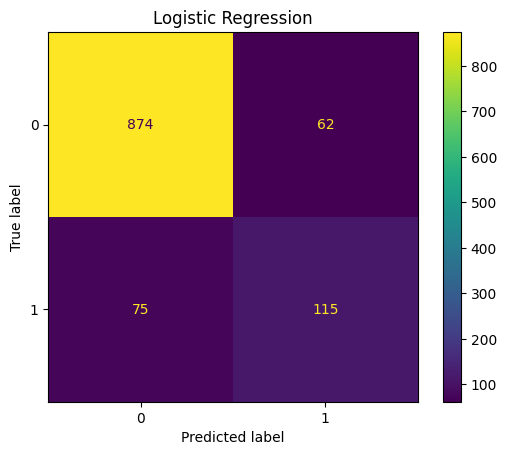

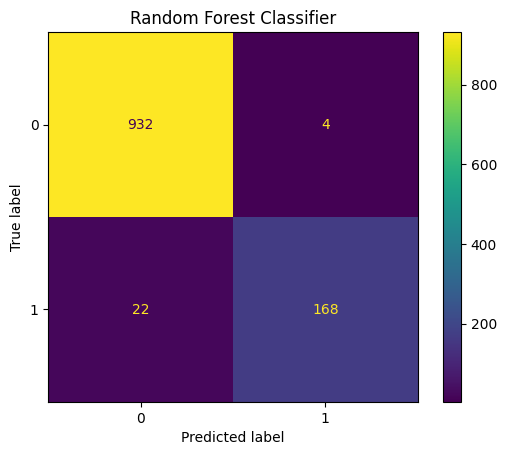

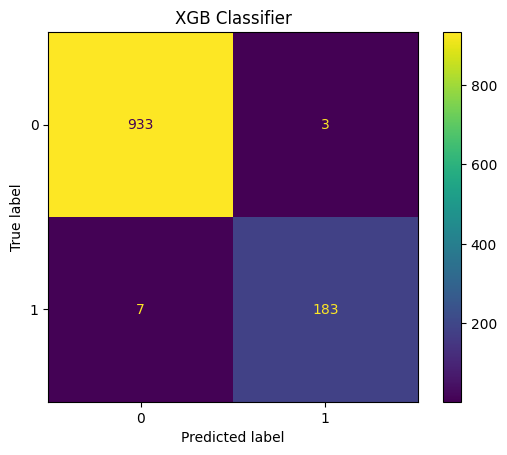

In [8]:
# Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, roc_auc_score, recall_score,
                             ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import joblib

pipeline_lr = Pipeline([
    ('smote',SMOTE()),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression())
])

pipeline_rfc = Pipeline([
    ('smote',SMOTE()),
    ('scaler', MinMaxScaler()),
    ('model', RandomForestClassifier())
])

pipeline_xgb = Pipeline([
    ('smote',SMOTE()),
    ('scaler', MinMaxScaler()),
    ('model', XGBClassifier())
])

pipelines = {
    'Logistic Regression':pipeline_lr,
    'Random Forest Classifier': pipeline_rfc,
    'XGB Classifier': pipeline_xgb,
}

for name, model in pipelines.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f'Metrics for {name}')
    print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
    print(f'Precision: {precision_score(y_test,y_pred)}')
    print(f'Precision: {recall_score(y_test,y_pred)}')
    print(f'AUC-ROC: {roc_auc_score(y_test,y_proba)}')

    ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)
    plt.title(f'{name}')

    print('='*50)

    joblib.dump(model,f'/home/cha/Desktop/Portfolio_Projects/Churn_Pred/models/{name.replace(" ", "_")}.pkl')


### Model Interpretations
- Both Models perform well with XGB slightly outperforming RFC. This means that XGB is slightly better at predicting churn vs. non-churn. Precision is the first priority in order to minimize false positives.

In [9]:
# Feature Importances

rfc = joblib.load('/home/cha/Desktop/Portfolio_Projects/Churn_Pred/models/Random_Forest_Classifier.pkl')
xgb = joblib.load('/home/cha/Desktop/Portfolio_Projects/Churn_Pred/models/XGB_Classifier.pkl')

rfc.named_steps['model'].feature_importances_
xgb.named_steps['model'].feature_importances_

for model in [rfc,xgb]:
    importances = model.named_steps['model'].feature_importances_

    feature_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance',ascending=False)

    print(feature_df.head(10))
    print("\n")




                        Feature  Importance
0                        Tenure    0.219060
35         MaritalStatus_Single    0.069429
12               CashbackAmount    0.065604
11            DaySinceLastOrder    0.062205
13             CashbackPerOrder    0.052653
2               WarehouseToHome    0.047016
8   OrderAmountHikeFromlastYear    0.039718
6               NumberOfAddress    0.033978
9                    CouponUsed    0.029021
34        MaritalStatus_Married    0.027530


                          Feature  Importance
34          MaritalStatus_Married    0.128957
33         MaritalStatus_Divorced    0.103432
0                          Tenure    0.092916
25                  Gender_Female    0.056415
35           MaritalStatus_Single    0.048827
23  PreferredPaymentMode_E wallet    0.039817
9                      CouponUsed    0.035609
7                        Complain    0.028117
31  PreferedOrderCat_Mobile Phone    0.026715
19       PreferredPaymentMode_COD    0.026023


